## Veronica Figueroa
## DATA1030
## Final Project

## Dataset Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.dummy import DummyClassifier
import shap

KeyboardInterrupt: 

## ----- 1. EDA -----

loading in csv files

In [210]:
injuries_df = pd.read_csv('C:/Users/lalaf/OneDrive/Brown/Fall2024/Data1030/NFL-Injury-Risk-Analysis/data/InjuryRecord.csv')
plays_df = pd.read_csv('C:/Users/lalaf/OneDrive/Brown/Fall2024/Data1030/NFL-Injury-Risk-Analysis/data/PlayList.csv')

In [211]:
# creating one df with "true/false" injury column

injury_plays = plays_df.copy()
injury_plays['InjuryStatus'] = injury_plays['PlayKey'].isin(injuries_df['PlayKey'])


print(injury_plays.head)

injury_plays.to_csv('Injury_Plays.csv', index=False)

<bound method NDFrame.head of         PlayerKey    GameID  ... PositionGroup InjuryStatus
0           26624   26624-1  ...            QB        False
1           26624   26624-1  ...            QB        False
2           26624   26624-1  ...            QB        False
3           26624   26624-1  ...            QB        False
4           26624   26624-1  ...            QB        False
...           ...       ...  ...           ...          ...
267000      47888  47888-13  ...            DB        False
267001      47888  47888-13  ...            DB        False
267002      47888  47888-13  ...            DB        False
267003      47888  47888-13  ...            DB        False
267004      47888  47888-13  ...            DB        False

[267005 rows x 15 columns]>


In [212]:
# prep the two datasets for merging, handle missing PlayKey values

print(f"Original dataset size: {injury_plays.shape[0]}")

missing_playkey_injuries = injuries_df[injuries_df['PlayKey'].isnull()]
static_fields = ['PlayerKey', 'GameID', 'RosterPosition', 'PlayerDay', 'StadiumType',
                 'FieldType', 'Temperature', 'Weather']
plays_df_unique = plays_df.drop_duplicates(subset=['PlayerKey', 'GameID'])
missing_playkey_filled = pd.merge(missing_playkey_injuries[['PlayerKey', 'GameID']], plays_df_unique[static_fields], 
                                  on=['PlayerKey', 'GameID'], how='left')

# some injuries are missing PlayKey - add and mark injured
missing_playkey_filled['InjuryStatus'] = True
full_injury_plays = pd.concat([injury_plays, missing_playkey_filled], ignore_index=True)
full_injury_plays.to_csv('Updated_Injury_Plays.csv', index=False)

# sanity checks
print(f"Original dataset size: {injury_plays.shape[0]}")
print(f"Updated dataset size: {full_injury_plays.shape[0]}")

print(f"Missing PlayKey injury records: {missing_playkey_injuries.shape[0]}")
print(f"Filled missing PlayKey injury records after merge: {missing_playkey_filled.shape[0]}")
duplicates = injury_plays[['PlayerKey', 'GameID']].merge(missing_playkey_filled[['PlayerKey', 'GameID']], 
                                                         on=['PlayerKey', 'GameID'], how='inner')
print(f"Number of duplicates (already in injury_plays): {duplicates.shape[0]}")



Original dataset size: 267005
Original dataset size: 267005
Updated dataset size: 267033
Missing PlayKey injury records: 28
Filled missing PlayKey injury records after merge: 28
Number of duplicates (already in injury_plays): 929


**Visualization**

In [213]:
# merge based on PlayerKey and GameID

pd.set_option('display.max_rows', 10) 
pd.set_option('display.max_columns', 5) 

merged_injury_data = pd.merge(
    injuries_df, 
    plays_df[['PlayerKey', 'GameID', 'RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType',
              'Temperature', 'Weather']],
    how='left', on=['PlayerKey', 'GameID']
)
merged_injury_data = merged_injury_data.drop_duplicates(subset=['PlayerKey', 'GameID'])

# sanity check
print(merged_injury_data)


      PlayerKey    GameID  ... Temperature          Weather
0         39873   39873-4  ...          84           Cloudy
32        46074   46074-7  ...          76    Partly Cloudy
58        36557   36557-1  ...          63   Clear and warm
128       46646   46646-3  ...          80           Cloudy
158       43532   43532-5  ...          89    Partly Cloudy
...         ...       ...  ...         ...              ...
3292      44423  44423-13  ...          73     Mostly sunny
3319      31933  31933-20  ...          84    Partly Cloudy
3345      47285   47285-4  ...          68              NaN
3361      37068  37068-19  ...          56  Clear and Sunny
3381      36696  36696-24  ...          68              NaN

[104 rows x 16 columns]


In [ ]:
# handling random problem with Temperature: random -999s
print(merged_injury_data['Temperature'].describe())

# replace -999 with NaN in the 'Temperature' column
merged_injury_data['Temperature'] = merged_injury_data['Temperature'].replace(-999, np.nan)
injury_plays['Temperature'] = injury_plays['Temperature'].replace(-999, np.nan)
print(merged_injury_data['Temperature'].describe())

        PlayerKey    GameID  ... Position PositionGroup
7162        31070   31070-1  ...       RB            RB
7163        31070   31070-1  ...       RB            RB
7164        31070   31070-1  ...       RB            RB
7165        31070   31070-1  ...       RB            RB
7166        31070   31070-1  ...       RB            RB
...           ...       ...  ...      ...           ...
266372      47813  47813-11  ...       CB            DB
266373      47813  47813-11  ...       CB            DB
266374      47813  47813-11  ...       CB            DB
266375      47813  47813-11  ...       CB            DB
266376      47813  47813-11  ...       CB            DB

[89749 rows x 14 columns]
        PlayerKey   GameID  ... Position PositionGroup
7162        31070  31070-1  ...       RB            RB
8578        31933  31933-1  ...       TE            TE
10612       33337  33337-1  ...       TE            TE
11402       33474  33474-1  ...       FS            DB
17208       34347  34347-1

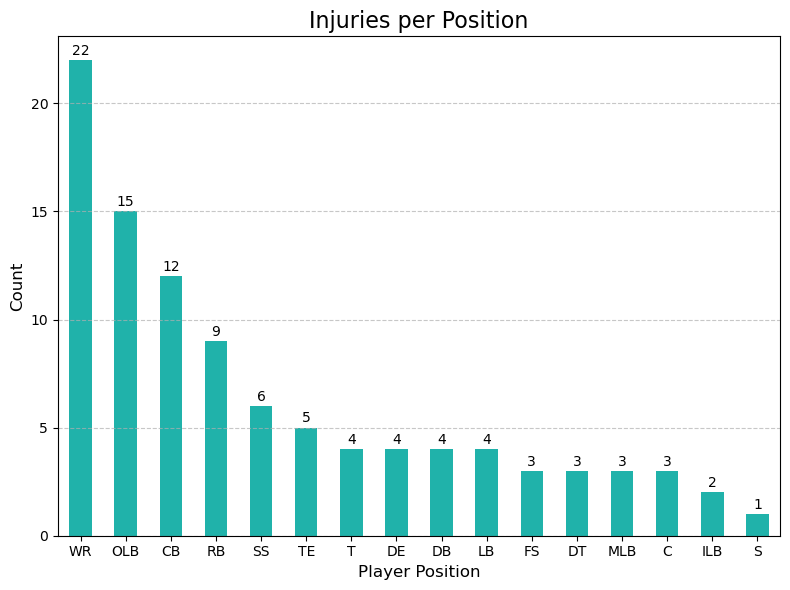

In [214]:
# Injuries by Poisition graph
play_data_subset = plays_df[plays_df['PlayerKey'].isin(injuries_df['PlayerKey'])]
print(play_data_subset)
play_data_subset.to_csv('JustInjured.csv', index=False)
play_data_subset = play_data_subset.drop_duplicates(subset=['PlayerKey'])
print(play_data_subset)

pos_counts = play_data_subset['Position'].value_counts()
plt.figure(figsize=(8, 6))
bars = pos_counts.plot(kind='bar', color=['lightseagreen'])
plt.title('Injuries per Position', fontsize=16)
plt.xlabel('Player Position', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, count in enumerate(pos_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

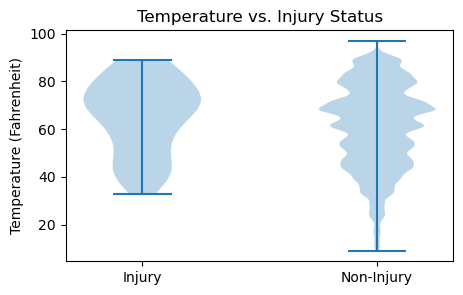

In [217]:
# Temperature by Injuries graph
dataset = [merged_injury_data['Temperature'].dropna().values,
           injury_plays[injury_plays['InjuryStatus']==False]['Temperature'].dropna().values]

plt.figure(figsize=(5,3))

plt.violinplot(dataset=dataset)
plt.xticks([1, 2], ['Injury', 'Non-Injury'])
plt.ylabel('Temperature (Fahrenheit)')
plt.title('Temperature vs. Injury Status')
plt.show()

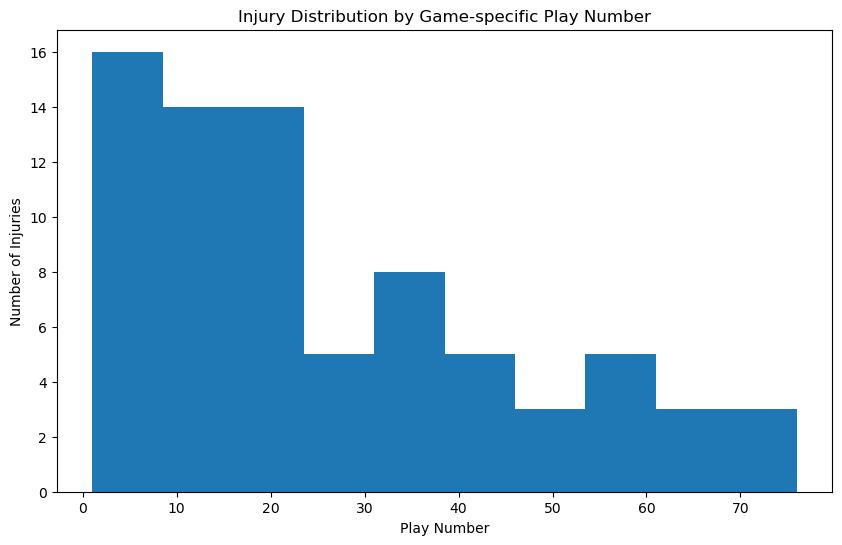

In [219]:
# Injuries by Play Number graph
injury_data = injury_plays[injury_plays['InjuryStatus'] == True]

plt.figure(figsize=(10, 6))
plt.hist(injury_data['PlayerGamePlay'], bins=10)
plt.title('Injury Distribution by Game-specific Play Number')
plt.xlabel('Play Number')
plt.ylabel('Number of Injuries')
plt.show()

(76, 15)


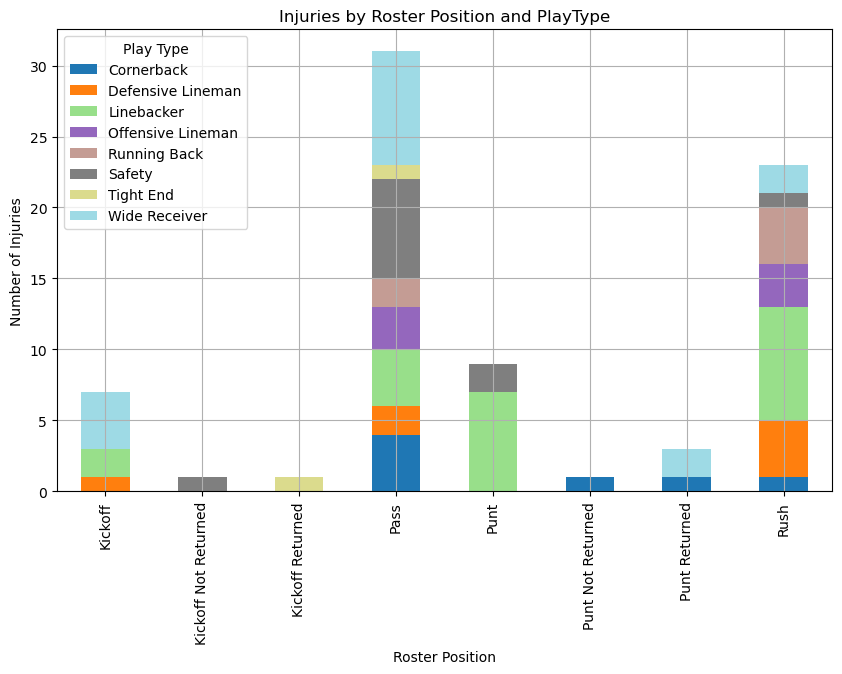

In [220]:
# Injuries by Roster Position and Play Type
injury_data = injury_plays[injury_plays['InjuryStatus'] == True]
print(injury_data.shape)

grouped_data = injury_data.groupby(['PlayType', 'RosterPosition']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Injuries by Roster Position and PlayType')
plt.xlabel('Roster Position')
plt.ylabel('Number of Injuries')
plt.grid(True)
plt.legend(title='Play Type')
plt.show()

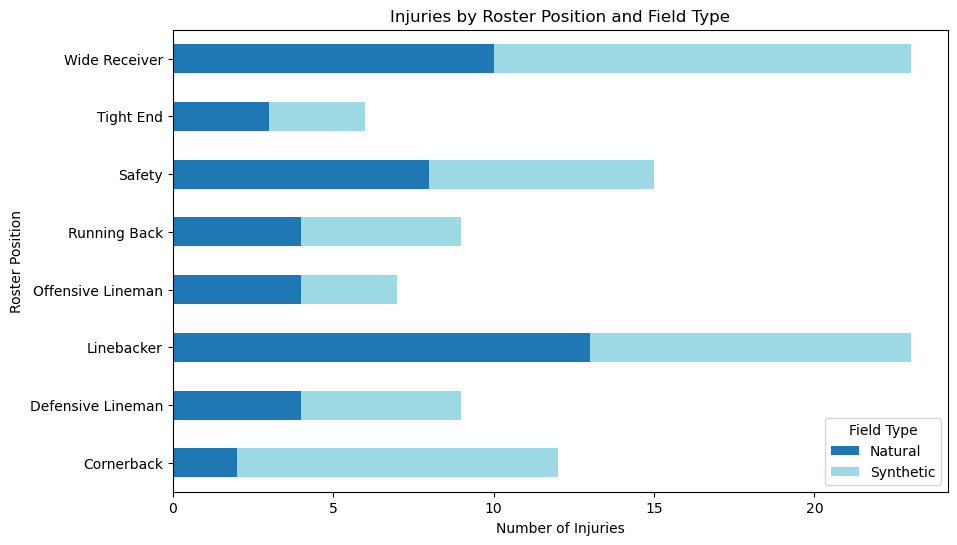

In [221]:
# Injuries by Roster Position and Field Type graph
grouped_data = merged_injury_data.groupby(['RosterPosition', 'FieldType']).size().unstack(fill_value=0)

grouped_data.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Injuries by Roster Position and Field Type')
plt.ylabel('Roster Position')
plt.xlabel('Number of Injuries')
plt.legend(title='Field Type')
plt.show()

## Missing Values

In [222]:
# find fraction and types of missing values, rows with missing values
print('Data dimensions:', full_injury_plays.shape)

perc_missing_per_ftr = full_injury_plays.isnull().sum(axis=0) / full_injury_plays.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('Data types of the features with missing values:')
print(full_injury_plays[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(full_injury_plays.isnull().sum(axis=1) != 0) / full_injury_plays.shape[0]
print('Fraction of points with missing values:', frac_missing)


Data dimensions: (267033, 15)
Fraction of missing values in features:
PlayKey           0.000105
PlayerGame        0.000105
StadiumType       0.063329
Weather           0.070010
PlayType          0.001479
PlayerGamePlay    0.000105
Position          0.000105
PositionGroup     0.000105
dtype: float64
Data types of the features with missing values:
PlayKey            object
PlayerGame        float64
StadiumType        object
Weather            object
PlayType           object
PlayerGamePlay    float64
Position           object
PositionGroup      object
dtype: object
Fraction of points with missing values: 0.131208502319938


## ----- 2. Splitting -----

In [223]:
# Dataset dimensions
print("Number of data points in the og dataset set:", full_injury_plays.shape[0])
print("Number of features in the og dataset set:", full_injury_plays.shape[1])

Number of data points in the og dataset set: 267033
Number of features in the og dataset set: 15


In [224]:
# feature matrix and target variable
feature_cols = ['RosterPosition', 'PlayerDay', 'PlayerGame', 'StadiumType', 'FieldType', 
                'Temperature', 'Weather', 'PlayType', 'PlayerGamePlay', 'Position', 'PositionGroup']
X = full_injury_plays[feature_cols]
y = full_injury_plays['InjuryStatus']

In [225]:
groups = full_injury_plays['PlayerKey']
print(groups.head())

0    26624
1    26624
2    26624
3    26624
4    26624
Name: PlayerKey, dtype: int64


4. Split Data Using GroupShuffleSplit

In [226]:
# split data - GroupShuffleSplit cuz non-i.i.d

# test and other
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=17)
for train_temp_idx, test_idx in gss.split(X, y, groups):
    X_train_temp, X_test = X.iloc[train_temp_idx], X.iloc[test_idx]
    y_train_temp, y_test = y.iloc[train_temp_idx], y.iloc[test_idx]
    groups_train_temp = groups.iloc[train_temp_idx]

# train and val
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in gss_inner.split(X_train_temp, y_train_temp, groups_train_temp):
    X_train, X_val = X_train_temp.iloc[train_idx], X_train_temp.iloc[val_idx]
    y_train, y_val = y_train_temp.iloc[train_idx], y_train_temp.iloc[val_idx]
    groups_train, groups_val = groups_train_temp.iloc[train_idx], groups_train_temp.iloc[val_idx]

# sanity checks
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Validation set class distribution:\n{y_val.value_counts(normalize=True)}")
print(f"Test set class distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: (162839, 11)
Validation set size: (45963, 11)
Test set size: (58231, 11)


## ----- 3. Preprocess -----

In [227]:
# Standardizing Categories
        # many of my features have multiple possible values that mean the same thing
        # concatenating the synonyms

# Stadium - indoor or outdoor
INDOOR = ['Closed Dome', 'Dome', 'Dome, closed', 'Domed', 'Domed, closed', 'Indoor', 'Indoor, Roof Closed',
          'Indoors', 'Retr. Roof - Closed', 'Retr. Roof Closed', 'Retr. Roof-Closed']
OUTDOOR = ['Bowl', 'Cloudy', 'Domed, Open', 'Domed, open', 'Heinz Field', 'Indoor, Open Roof', 'Open',
           'Oudoor', 'Ourdoor', 'Outddors', 'Outdoor', 'Outdoor Retr Roof-Open', 'Outdoors', 'Outdor',
           'Outside', 'Retr. Roof - Open', 'Retr. Roof-Open', 'Retractable Roof']
full_injury_plays['StadiumType'] = ['Indoor' if k in INDOOR
                               else 'Outdoor' if k in OUTDOOR
                               else 'Unknown' for k in full_injury_plays['StadiumType']]

# Weather - Clear, Rain, Clouds, Snow, or Indoor
CLEAR = ['Clear','Clear Skies','Clear and Cool','Clear and Sunny','Clear and cold','Clear and sunny',
         'Clear and warm', 'Clear skies', 'Clear to Partly Cloudy', 'Cold', 'Fair', 'Heat Index 95',
         'Mostly Sunny', 'Mostly Sunny Skies', 'Mostly sunny', 'Partly Sunny', 'Partly clear',
         'Partly sunny', 'Sun & clouds', 'Sunny', 'Sunny Skies', 'Sunny and clear', 'Sunny and cold',
         'Sunny and warm', 'Sunny, Windy', 'Sunny, highs to upper 80s']
RAIN = ['10% Chance of Rain', '30% Chance of Rain', 'Showers',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy, 50% change of rain', 'Cloudy, Rain', 'Cloudy, chance of rain', 'Light Rain', 'Rain',
        'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers']
CLOUDS = ['Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
          'Coudy', 'Hazy', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly cloudy', 'Overcast', 'Partly Cloudy',
          'Partly Clouidy', 'Partly cloudy', 'Party Cloudy', 'cloudy']
SNOW = ['Cloudy, light snow accumulating 1-3"', 'Heavy lake effect snow', 'Snow']
INDOORS = ['Controlled Climate', 'Indoor', 'Indoors', 'N/A (Indoors)', 'N/A Indoor']
full_injury_plays['Weather'] = ['Clear' if k in CLEAR
                           else 'Rain' if k in RAIN
                           else 'Clouds' if k in CLOUDS
                           else 'Snow' if k in SNOW
                           else 'Indoor' if k in INDOORS
                           else 'Unknown' for k in full_injury_plays['Weather']]

# Play Type - Punt, Kickoff (Run and Pass are already solid)
PUNT = ['Punt', 'Punt Returned', 'Punt Not Returned']
KICKOFF = ['Kickoff', 'Kickoff Returned', 'Kickoff Not Returned']
full_injury_plays['PlayType'] = ['Punt' if k in PUNT
                            else 'Kickoff' if k in KICKOFF
                            else k for k in full_injury_plays['PlayType']]

full_injury_plays['PlayType'] = full_injury_plays['PlayType'].replace('0', 'Unknown')
full_injury_plays['Position'] = full_injury_plays['Position'].replace('Missing Data', 'Unknown')
full_injury_plays['PositionGroup'] = full_injury_plays['PositionGroup'].replace('Missing Data', 'Unknown')

# TEMP BOT
# full_injury_plays = full_injury_plays[full_injury_plays['PlayerDay'] != np.nan]
full_injury_plays = full_injury_plays[pd.notnull(full_injury_plays['PlayerDay'])]

full_injury_plays = full_injury_plays[full_injury_plays['PlayerGame'] != np.nan]
full_injury_plays = full_injury_plays[full_injury_plays['PlayerGamePlay'] != np.nan]
full_injury_plays = full_injury_plays[full_injury_plays['Temperature'] != np.nan]

In [229]:
# Preprocessing:
    # Simple Imputer for missing values since there aren't many, but many rows depend on them
    # Categorical = one-hot encoding
    # Numerical = standard scaler

categorical_cols = ['RosterPosition', 'StadiumType', 'FieldType', 'Weather', 'PlayType', 'Position', 'PositionGroup']
numerical_cols = ['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay']

# preprocessors
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# # ---- APPLYING SMOTE ---------
# # Step 5: Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)
# # Debugging: Check the new class distribution
# print("Class distribution after SMOTE:")
# print(pd.Series(y_train_resampled).value_counts())

# # Step 4: Debug the output
# print(f"Transformed Training Set Shape: {X_train_transformed.shape}")
# print(f"First few rows of transformed training set:\n{X_train_transformed[:5]}")

# Sanity Checks
print("Transformed training set shape:", X_train_transformed.shape)
print("Transformed validation set shape:", X_val_transformed.shape)
print("Transformed test set shape:", X_test_transformed.shape)

Class distribution after SMOTE:
InjuryStatus
False    162768
True     162768
Name: count, dtype: int64
Transformed Training Set Shape: (162839, 151)
First few rows of transformed training set:
[[-1.12911914 -1.52767287  0.36098117 -1.42241973  0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          

## ----- 4. Evaluation Metric -----

I'm choosing *recall* as my evaluation metric because:
- I have an imbalanced dataset, so I shouldn't choose a metric that relies on TNs (there will be many regardless)
- I care about injury prevention, so I'd rather have a FP rather than a FN

## ----- 5. & 6. ML Algorithms & Cross-Validation-----

Hyperparameter Printing helper functions

In [ ]:
def print_hyperparams(results_df, model_name):
    print(f"\nHyperparameter Tuning Results for {model_name}:")
    for idx, row in results_df.iterrows():
        print(f"  Params: {row['params']}")
        print(f"    Mean Validation Recall: {row['mean_test_score']:.4f}")
        print(f"    Std Validation Recall: {row['std_test_score']:.4f}")

def evaluate_model(y_test, y_test_pred, y_test_pred_proba=None, model_name=None):
    test_recall = recall_score(y_test, y_test_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print(f"\nTest Set Performance for {model_name}:")
    print(f"Recall: {test_recall:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Injury", "Injury"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    return test_recall

**LOGISTIC REGRESSION**

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Hyperparameter Tuning Results:
  Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
    Mean Validation Recall: 0.2246
    Std Validation Recall: 0.0494
  Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
    Mean Validation Recall: 0.1679
    Std Validation Recall: 0.0666
  Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
    Mean Validation Recall: 0.1401
    Std Validation Recall: 0.0507
  Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
    Mean Validation Recall: 0.1401
    Std Validation Recall: 0.0507
  Params: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
    Mean Validation Recall: 0.1262
    Std Validation Recall: 0.0326

Best Model Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Validation Recall: 0.2246

Test Set Performance:
Test Recall: 0.3500
              precision    recall  f1-score   support

       False       1.00      0.87      0.93     58211
        True       0.00   

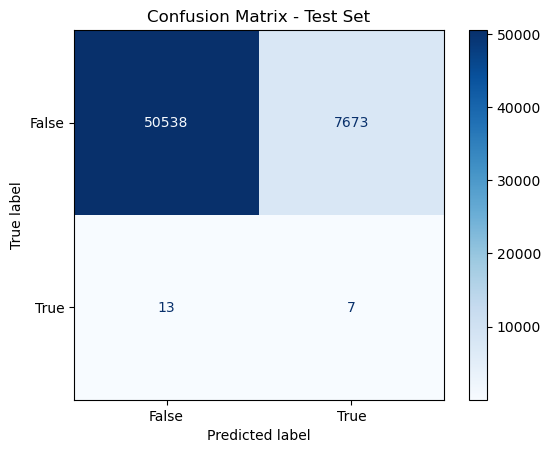

In [252]:
logistic_model = LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced')

# hyperparams & GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    scoring='recall', 
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_transformed, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)

print_hyperparams(results_df, "Logistic Regression")

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_transformed)
log_reg_recall = evaluate_model(y_test, y_test_pred, model_name="Logistic Regression")


# setting up metrics dictionary to compare later 
# (will add the other model's test, mean, and std dev recalls)
metrics_dict = {}
metrics_dict["Logistic Regression"] = log_reg_recall
metrics_dict["Logistic Regression"] = {
    "mean_recall": grid_search.best_score_, 
    "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0] 
}

# logistic_model = LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced')

# # hyperparams & GridSearch
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'solver': ['lbfgs']
# }

# grid_search = GridSearchCV(
#     estimator=logistic_model,
#     param_grid=param_grid,
#     scoring='recall', 
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_transformed, y_train)
# results_df = pd.DataFrame(grid_search.cv_results_)

# # formatting outputs
# print("Hyperparameter Tuning Results:")
# for idx, row in results_df.iterrows():
#     print(f"  Params: {row['params']}")
#     print(f"    Mean Validation Recall: {row['mean_test_score']:.4f}")
#     print(f"    Std Validation Recall: {row['std_test_score']:.4f}")\

# # Print the best model parameters
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# print(f"\nBest Model Parameters: {best_params}")
# print(f"Best Validation Recall: {best_score:.4f}")

# best_model = grid_search.best_estimator_
# y_test_pred = best_model.predict(X_test_transformed)
# test_recall = recall_score(y_test, y_test_pred, average='binary')
# log_reg_recall = test_recall

# # setting up metrics dictionary to compare later 
# # (will add the other model's test, mean, and std dev recalls)
# metrics_dict = {}
# metrics_dict["Logistic Regression"] = log_reg_recall
# metrics_dict["Logistic Regression"] = {
#     "mean_recall": grid_search.best_score_, 
#     "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0] 
# }

# print("\nTest Set Performance:")
# print(f"Test Recall: {test_recall:.4f}")
# print(classification_report(y_test, y_test_pred))

# print(f"Recall: {test_recall:.4f}")

# # confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# print("\nConfusion Matrix:")
# print(conf_matrix)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
# disp.plot(cmap='Blues', values_format='d')
# plt.title("Logistic Regression Confusion Matrix")
# plt.show()

**RANDOM FOREST CLASSIFIER**

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Hyperparameter Tuning Results for Random Forest:
  Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    Mean Validation Recall: 0.2681
    Std Validation Recall: 0.0256
  Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    Mean Validation Recall: 0.2826
    Std Validation Recall: 0.0461
  Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    Mean Validation Recall: 0.2681
    Std Validation Recall: 0.0256
  Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
    Mean Validation Recall: 0.2681
    Std Validation Recall: 0.0256
  Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators'

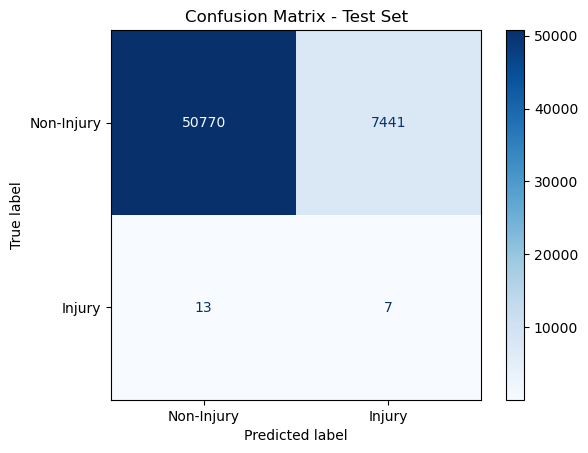

In [255]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# hyperparams
# class_weight to handle dataset imbalance!!
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [10, 20], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2], 
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# StratifiedKFold cross-validation 
# (ensuring proper distribution of classes between the folds)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='recall',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_transformed, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)

print_hyperparams(results_df, "Random Forest")

best_rf_model = grid_search.best_estimator_

y_test_pred_proba = best_rf_model.predict_proba(X_test_transformed)[:, 1]
threshold = 0.3
y_test_pred = (y_test_pred_proba >= threshold).astype(int)
rf_recall = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "Random Forest")

metrics_dict["Random Forest"] = {
    "mean_recall": grid_search.best_score_,
    "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0],
    "test_recall": rf_recall
}
# rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# # hyperparams
# # class_weight to handle dataset imbalance!!
# param_grid = {
#     'n_estimators': [100, 200], 
#     'max_depth': [10, 20], 
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2], 
#     'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
# }

# # StratifiedKFold cross-validation 
# # (ensuring proper distribution of classes between the folds)
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring='recall',
#     cv=skf,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_transformed, y_train)
# results_df = pd.DataFrame(grid_search.cv_results_)
# print("Hyperparameter Tuning Results for Random Forest:")
# for idx, row in results_df.iterrows():
#     print(f"  Params: {row['params']}")
#     print(f"    Mean Validation Recall: {row['mean_test_score']:.4f}")
#     print(f"    Std Validation Recall: {row['std_test_score']:.4f}")
# best_rf_model = grid_search.best_estimator_

# metrics_dict["Random Forest"] = {
#     "mean_recall": grid_search.best_score_,
#     "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0]
# }

# y_test_pred_proba = best_rf_model.predict_proba(X_test_transformed)[:, 1]
# threshold = 0.3
# y_test_pred = (y_test_pred_proba >= threshold).astype(int)
# recall = recall_score(y_test, y_test_pred, average='binary')
# rf_recall = recall

# print("\nTest Set Performance:")
# print(f"Recall: {recall:.4f}")

# # confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Injury", "Injury"])
# disp.plot(cmap='Blues', values_format='d')
# plt.title("Random Forest Classifier Confusion Matrix")
# plt.show()


**SUPPORT VECTOR MACHINE CLASSIFICATION** \
*NOTE:* Running this on anything over 10% took well over a day, so I subsampled that amount.

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Hyperparameter Tuning Results for SVM Classifier:
  Params: {'C': 0.01, 'gamma': 0.001}
    Mean Validation Recall: 0.3333
    Std Validation Recall: 0.471405
  Params: {'C': 0.01, 'gamma': 0.01}
    Mean Validation Recall: 0.5000
    Std Validation Recall: 0.408248
  Params: {'C': 0.01, 'gamma': 0.1}
    Mean Validation Recall: 0.0000
    Std Validation Recall: 0.000000
  Params: {'C': 0.01, 'gamma': 1.0}
    Mean Validation Recall: 0.0000
    Std Validation Recall: 0.000000
  Params: {'C': 0.01, 'gamma': 10.0}
    Mean Validation Recall: 0.0000
    Std Validation Recall: 0.000000
  Params: {'C': 0.1, 'gamma': 0.001}
    Mean Validation Recall: 0.5000
    Std Validation Recall: 0.408248
  Params: {'C': 0.1, 'gamma': 0.01}
    Mean Validation Recall: 0.0000
    Std Validation Recall: 0.000000
  Params: {'C': 0.1, 'gamma': 0.1}
    Mean Validation Recall: 0.0000
    Std Validation Recall: 0.000000
  Params: {'C': 0.1, 'gamma':

c:\Users\lalaf\anaconda3\envs\data1030\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


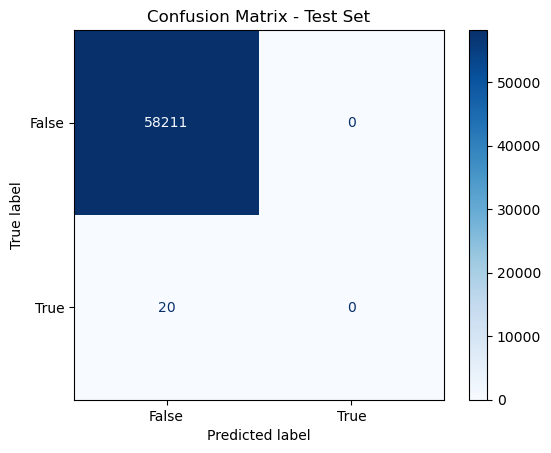

In [ ]:
# subsampling data
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_transformed, y_train, test_size=0.95, stratify=y_train, random_state=42
)

# using class_weight for class imbalance!!
svc_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# hyperparams
param_grid = {
    'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]
}
grid_search = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid,
    scoring='recall', 
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_sampled, y_train_sampled)
results_df = pd.DataFrame(grid_search.cv_results_)

print_hyperparams(results_df, "SVM Classifier")
best_svc_model = grid_search.best_estimator_
y_test_pred_proba = best_svc_model.predict_proba(X_test_transformed)[:, 1]
threshold = 0.3
y_test_pred = (y_test_pred_proba >= threshold).astype(int)

svc_recall = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "SVM Classifier")
metrics_dict["SVM Classifier"] = {
    "mean_recall": grid_search.best_score_,
    "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0],
    "test_recall": svc_recall
}

# # subsampling data
# X_train_sampled, _, y_train_sampled, _ = train_test_split(
#     X_train_transformed, y_train, test_size=0.95, stratify=y_train, random_state=42
# )

# # using class_weight for class imbalance!!
# svc_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# # hyperparams
# param_grid = {
#     'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
#     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]
# }
# grid_search = GridSearchCV(
#     estimator=svc_model,
#     param_grid=param_grid,
#     scoring='recall', 
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_sampled, y_train_sampled)
# results_df = pd.DataFrame(grid_search.cv_results_)

# print("Hyperparameter Tuning Results for SVM Classifier:")
# for idx, row in results_df.iterrows():
#     print(f"  Params: {row['params']}")
#     print(f"    Mean Validation Recall: {row['mean_test_score']:.4f}")
#     print(f"    Std Validation Recall: {row['std_test_score']:.6f}")

# metrics_dict["SVM Classifier"] = {
#     "mean_recall": grid_search.best_score_,
#     "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0]
# }

# print(f"Best Hyperparameters: {grid_search.best_params_}")


# best_svc_model = grid_search.best_estimator_
# y_test_pred_proba = best_svc_model.predict_proba(X_test_transformed)[:, 1]
# threshold = 0.3
# y_test_pred = (y_test_pred_proba >= threshold).astype(int)

# recall = recall_score(y_test, y_test_pred, average='binary')
# metrics_dict["SVM Classifier"]["test_recall"] = recall
# metrics_dict["SVM Classifier"] = {
#     "mean_recall": grid_search.best_score_,  # Mean validation recall
#     "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0]  # Std deviation
# }

# print(f"Recall: {recall:.4f}")

# # confusion matrix
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_svc_model.classes_)
# disp.plot(cmap='Blues', values_format='d')
# plt.title("SVM Classifier Confusion Matrix")
# plt.show()

**XGBOOST**

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\lalaf\anaconda3\envs\data1030\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:52] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Hyperparameter Tuning Results for XGBoost:
  Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2292.507042253521}
    Mean Validation Recall: 0.4958
    Std Validation Recall: 0.1424
  Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2292.507042253521}
    Mean Validation Recall: 0.4251
    Std Validation Recall: 0.1342
  Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 2292.507042253521}
    Mean Validation Recall: 0.3539
    Std Validation Recall: 0.0943
  Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'scale_pos_weight': 2292.507042253521}
    Mean Validation Recall: 0.3539
    Std Validation Recall: 0.0943
  Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 2292.507042253521}
    Mean Validation Recall: 0.3116
    Std Validation Recall: 0.0871
  Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200,

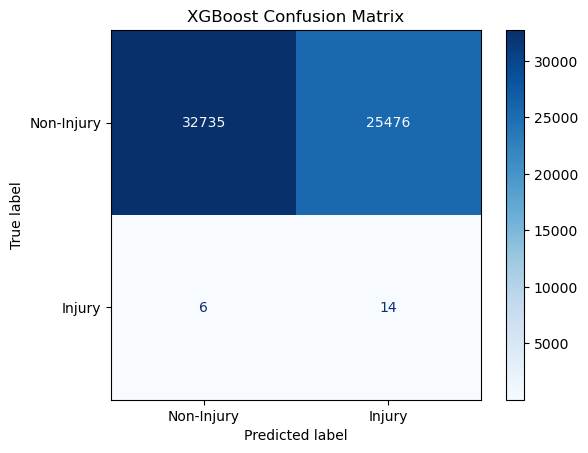

In [341]:
# using scale_pos_weight for class imbalance!!
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='recall', 
    random_state=42
)

# hyperparams
param_grid = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [scale_pos_weight]
}

# StratifiedKFold cross-validation 
# (ensuring proper distribution of classes between the folds)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall', 
    cv=skf,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_transformed, y_train)
results_df = pd.DataFrame(grid_search.cv_results_)

print_hyperparams(results_df, "XGBoost")

best_xgb_model = grid_search.best_estimator_
y_test_pred_proba = best_xgb_model.predict_proba(X_test_transformed)[:, 1]
threshold = 0.3 
y_test_pred = (y_test_pred_proba >= threshold).astype(int)

xgb_recall = evaluate_model(y_test, y_test_pred, y_test_pred_proba, "XGBoost")
metrics_dict["XGBoost"] = {
    "mean_recall": grid_search.best_score_,
    "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0],
    "test_recall": xgb_recall
}
# # using scale_pos_weight for class imbalance!!
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# xgb_model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='recall', 
#     random_state=42
# )

# # hyperparams
# param_grid = {
#     'max_depth': [3, 5, 10],
#     'learning_rate': [0.1, 0.3],
#     'n_estimators': [50, 100, 200],
#     'scale_pos_weight': [scale_pos_weight]
# }

# # StratifiedKFold cross-validation 
# # (ensuring proper distribution of classes between the folds)
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='recall', 
#     cv=skf,
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_transformed, y_train)
# results_df = pd.DataFrame(grid_search.cv_results_)
# print("Hyperparameter Tuning Results for XGBoost:")
# for idx, row in results_df.iterrows():
#     print(f"  Params: {row['params']}")
#     print(f"    Mean Validation Recall: {row['mean_test_score']:.4f}")
#     print(f"    Std Validation Recall: {row['std_test_score']:.4f}")

# metrics_dict["XGBoost"] = {
#     "mean_recall": grid_search.best_score_,
#     "std_recall": results_df[results_df['params'] == grid_search.best_params_]['std_test_score'].values[0]
# }
# best_xgb_model = grid_search.best_estimator_
# y_test_pred_proba = best_xgb_model.predict_proba(X_test_transformed)[:, 1]
# threshold = 0.3 
# y_test_pred = (y_test_pred_proba >= threshold).astype(int)

# recall = recall_score(y_test, y_test_pred, average='binary')
# metrics_dict["XGBoost"]["test_recall"] = recall

# print("\nTest Set Performance:")
# print(f"Recall: {recall:.4f}")

# # confusion matrix
# cm = confusion_matrix(y_test, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Injury", "Injury"])
# disp.plot(cmap='Blues')
# plt.title("XGBoost Confusion Matrix")
# plt.show()

## ----- 7. Interpretation -----

In [249]:
# getting baseline recall
dummy_model = DummyClassifier(strategy='most_frequent') 
dummy_model.fit(X_train_transformed, y_train)
y_test_dummy_pred = dummy_model.predict(X_test_transformed)

dummy_recall = recall_score(y_test, y_test_dummy_pred, average='binary')

print("\nBaseline (Majority Class) Model Performance:")
print(f"Recall: {dummy_recall:.4f}")


Baseline (Majority Class) Model Performance:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.9997


c:\Users\lalaf\anaconda3\envs\data1030\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [339]:
# printing and plotting all ML algo recalls
print("Metrics for All Models:")
for model, metrics in metrics_dict.items():
    if isinstance(metrics, dict):
        mean_recall = metrics.get("mean_recall", "N/A")
        std_recall = metrics.get("std_recall", "N/A")
        test_recall = metrics.get("test_recall", "N/A")
        print(f"{model} - Mean Recall: {mean_recall:.4f}, Std Recall: {std_recall:.4f}, Test Recall: {test_recall}")
    else:
        print(f"{model}: {metrics:.4f}")

model_names = []
mean_recalls = []
std_recalls = []
test_scores = [] 
for model, metrics in metrics_dict.items():
    if isinstance(metrics, dict): 
        model_names.append(model)
        mean_recalls.append(metrics["mean_recall"])
        std_recalls.append(metrics["std_recall"])
        test_scores.append(metrics["test_recall"])

plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_recalls, yerr=std_recalls, capsize=5, color='skyblue', alpha=0.8, label='Mean Recall ± Std Dev')
plt.scatter(model_names, test_scores, color='orange', label='Test Scores')

plt.ylabel("Recall")
plt.xlabel("Models")
plt.title("Mean Recall, Standard Deviation, and Test Scores Across Models")
plt.ylim(0, 1)  
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Metrics for All Models:
SVM Classifier - Mean Recall: 0.5000, Std Recall: 0.4082, Test Recall: 0
Logistic Regression - Mean Recall: 0.2246, Std Recall: 0.0494, Test Recall: 0.35
Random Forest - Mean Recall: 0.2826, Std Recall: 0.0461, Test Recall: 0.35
XGBoost - Mean Recall: 0.4958, Std Recall: 0.1424, Test Recall: 0.7


*NOTE:* XGBoost was the best model, so all further interpretation is centered around that model.

# SHAP Global Importance

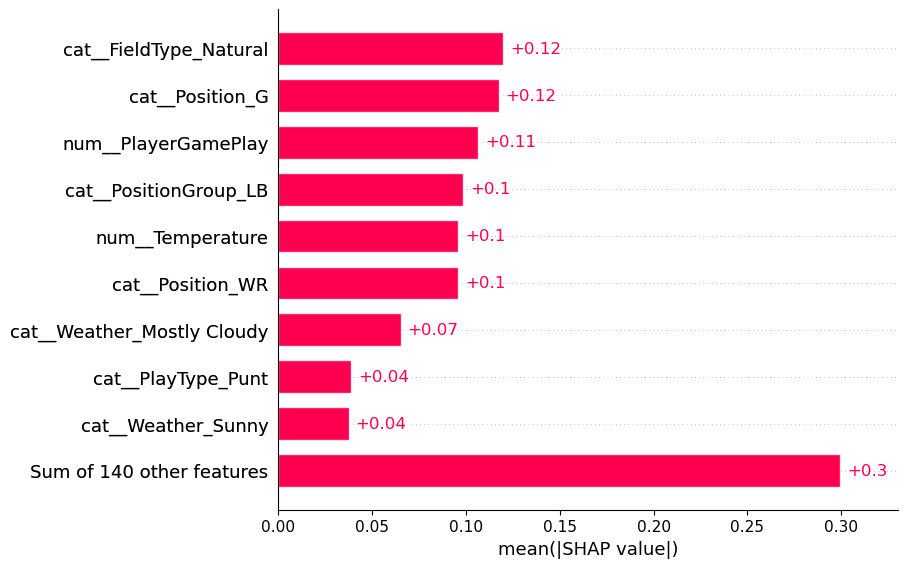

In [326]:
background = shap.sample(X_train_transformed) 
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value, 
    data=X_test_transformed, 
    feature_names=preprocessor.get_feature_names_out())

# removing 'PlayerDay' and 'PlayerGame' from the SHAP explanation
# (reason: these are merely indexing values between the original dataset; NOT predictive or indicative of features)
features_to_exclude = ['num__PlayerDay', 'num__PlayerGame']
filtered_indices = ~np.isin(shap_explanation.feature_names, features_to_exclude)

filtered_explanation = shap.Explanation(
    values=shap_explanation.values[:, filtered_indices],
    base_values=shap_explanation.base_values,
    data=shap_explanation.data[:, filtered_indices],
    feature_names=np.array(shap_explanation.feature_names)[filtered_indices]
)

# showing top 10 features
shap.plots.bar(filtered_explanation, max_display=10) 

In [ ]:
import numpy as np
import shap

# (excluded features for same reasons as stated above)
features_to_exclude = ['num__PlayerDay', 'num__PlayerGame']

feature_names = preprocessor.get_feature_names_out()
filtered_indices = ~np.isin(feature_names, features_to_exclude)

filtered_shap_values = shap_values[:, filtered_indices]
filtered_feature_names = feature_names[filtered_indices]
filtered_X_test_transformed = X_test_transformed[:, filtered_indices]

shap.summary_plot(filtered_shap_values, filtered_X_test_transformed, feature_names=filtered_feature_names)

# SHAP Local Importance

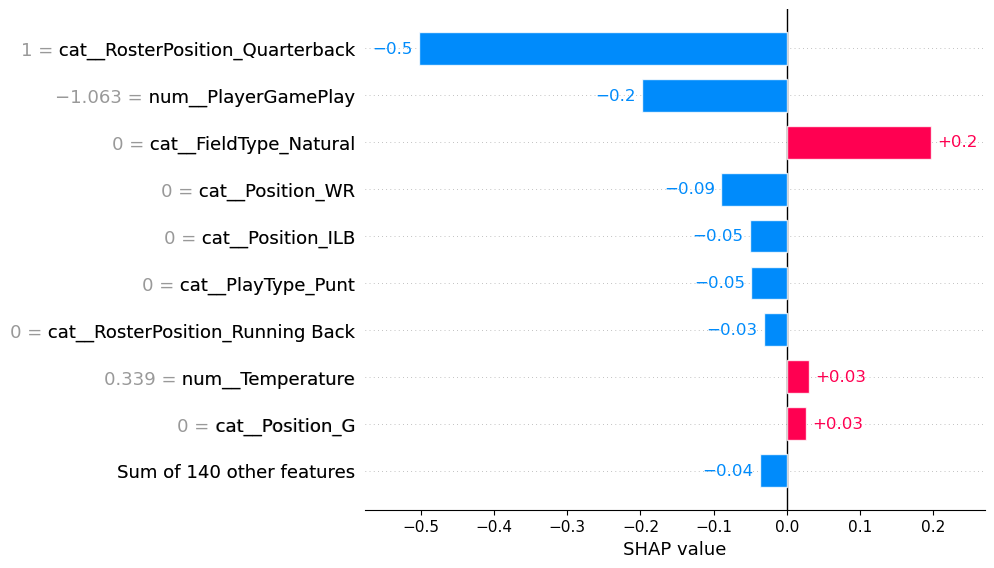

In [327]:
import numpy as np
import shap

# random instance
instance_index = 7

shap_value_instance = shap_explanation[instance_index]

# (excluded features for same reasons as stated above)
features_to_exclude = ['num__PlayerDay', 'num__PlayerGame']
filtered_indices = ~np.isin(shap_value_instance.feature_names, features_to_exclude)

filtered_explanation_instance = shap.Explanation(
    values=shap_value_instance.values[filtered_indices],
    base_values=shap_value_instance.base_values,
    data=shap_value_instance.data[filtered_indices],
    feature_names=np.array(shap_value_instance.feature_names)[filtered_indices]
)

shap.plots.bar(filtered_explanation_instance)


In [345]:
# force plot generation

instance_index = 7 
shap_value_instance = shap_values[instance_index] 
feature_values_instance = X_test_transformed[instance_index, :] 
feature_names_transformed = preprocessor.get_feature_names_out() 

force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_value_instance, 
    features=feature_values_instance,
    feature_names=feature_names_transformed 
)

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_value_instance,
    features=feature_values_instance,
    feature_names=feature_names_transformed
)

# saving as HMTL because the plot isn't showing up in VSCode
shap.save_html("force_plot.html", force_plot)

# End of project!